In [39]:
!pip install autoviz -q

In [40]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from autoviz.AutoViz_Class import AutoViz_Class
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import (train_test_split, cross_val_score,
                                    KFold, GridSearchCV)
from scipy import stats
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import (train_test_split, cross_val_score,
                                    KFold, GridSearchCV)

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge

import xgboost as xgb
import lightgbm as lgb

In [42]:
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./test.csv')

train_ID = train['Id']
valid_ID = valid['Id']

train.drop("Id", axis = 1, inplace = True)
valid.drop("Id", axis = 1, inplace = True)

print('Train:{}   Valid:{}'.format(train.shape, valid.shape))

Train:(1460, 80)   Valid:(1459, 79)


# EDA & VISUALIZATION

In [43]:
AV = AutoViz_Class()
df_av = AV.AutoViz('../input/house-prices-advanced-regression-techniques/train.csv');

    pandas ascii encoder does not work for this file. Continuing...
    pandas utf-8 encoder does not work for this file. Continuing...
    pandas iso-8859-1 encoder does not work for this file. Continuing...
    pandas cp1252 encoder does not work for this file. Continuing...
    pandas latin1 encoder does not work for this file. Continuing...
Not able to read or load file. Please check your inputs and try again...


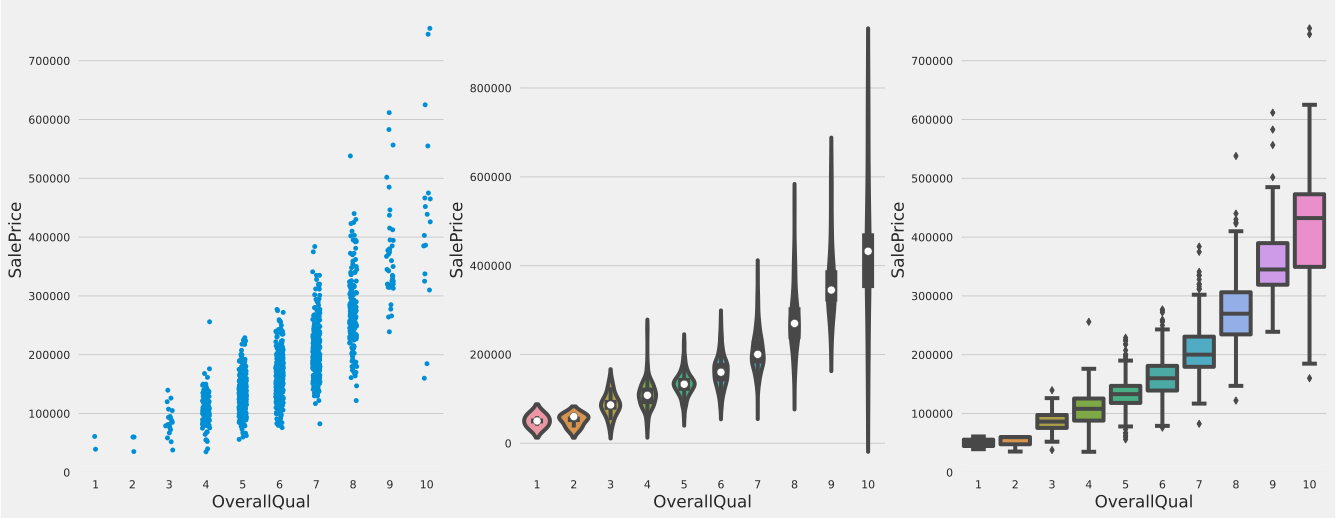

In [44]:
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=train, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=train, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

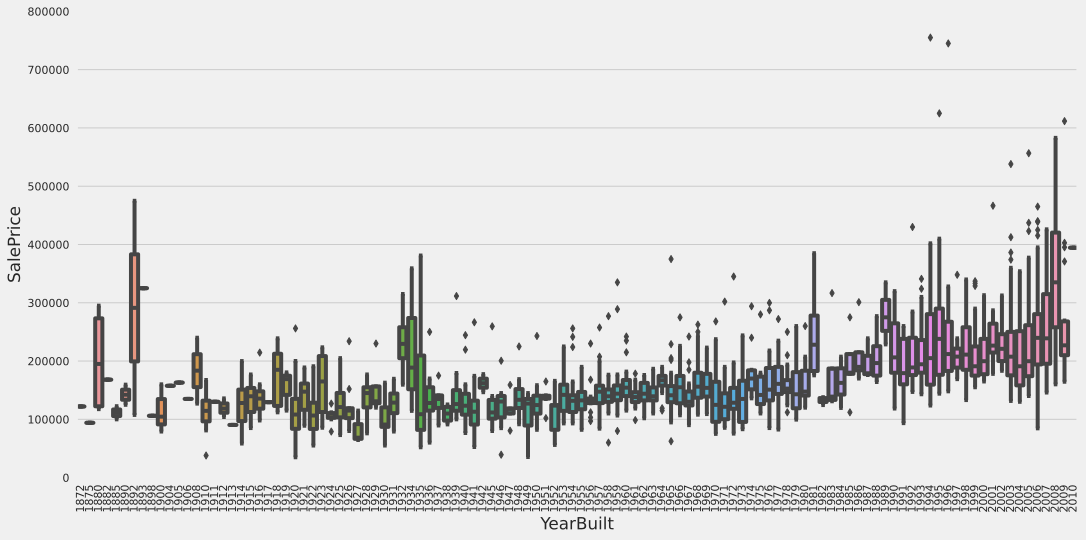

In [45]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Log-transformation of the variables

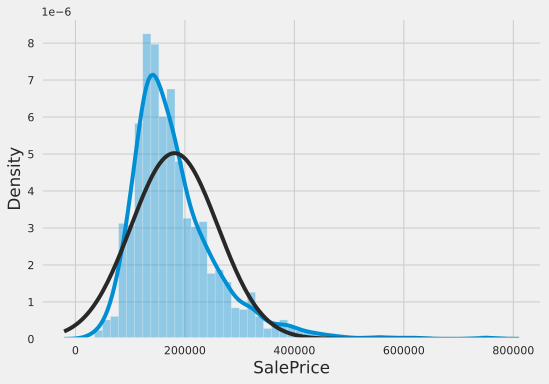

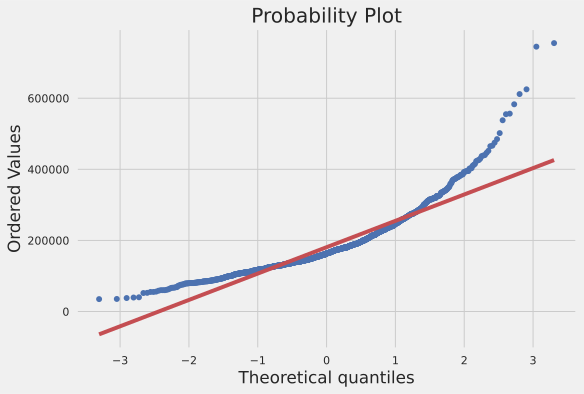

In [46]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [47]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


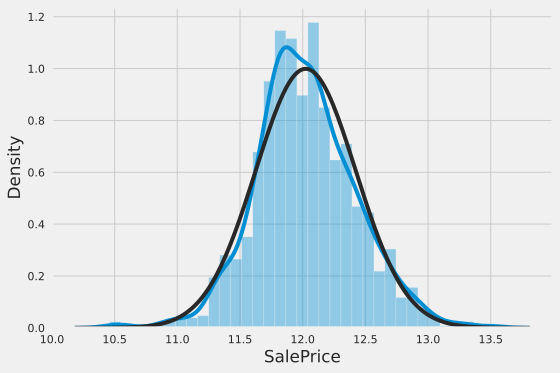

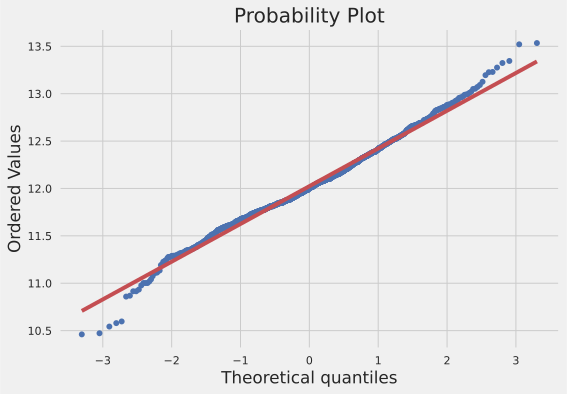

In [48]:
train['SalePrice'] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)



In [49]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


# Feature Engineering

In [50]:
ntrain = train.shape[0]
nvalid = valid.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, valid)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [51]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:7]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(7)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071


In the data description, it said that for certain variables, NA means that the house has no some  specifications.For example, FireplaceQu:  NA means house don't have fireplace. So we need to replace Na with None to don't lose descriptive power.

In [52]:
none_list = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2','MasVnrType','MSSubClass']

zero_list = ['GarageYrBlt', 'GarageArea', 'GarageCars',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
            'MasVnrArea']

drop_list = ['Utilities']

for el in none_list:
    all_data[el] = all_data[el].fillna("None")

for el in zero_list:
    all_data[el] = all_data[el].fillna(0)

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data = all_data.drop(drop_list, axis=1)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()


,Missing Ratio


In [53]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data["SqFtPerRoom"] = all_data["GrLivArea"] / (all_data["TotRmsAbvGrd"] +
                                                       all_data["FullBath"] +
                                                       all_data["HalfBath"] +
                                                       all_data["KitchenAbvGr"])

all_data['Total_Home_Quality'] = all_data['OverallQual'] + all_data['OverallCond']

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data["HighQualSF"] = all_data["GrLivArea"]+all_data["1stFlrSF"] + all_data["2ndFlrSF"]
+0.5*all_data["GarageArea"]+0.5*all_data["TotalBsmtSF"]+1*all_data["MasVnrArea"]

0        898.0
1        861.0
2        926.0
3        699.0
4       1340.5
         ...  
2914     273.0
2915     416.0
2916     900.0
2917     456.0
2918     917.0
Length: 2919, dtype: float64

In [54]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


In [55]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (2919, 83)


In [56]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [57]:
kewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 63 skewed numerical features to Box Cox transform


In [58]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 225)


In [59]:
train_df = all_data[:ntrain]
valid_df = all_data[ntrain:]

# Modeling

In [60]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse= np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [61]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [62]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1242 (0.0165)



In [63]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1242 (0.0166)



In [64]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1260 (0.0128)



In [65]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =42)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1237 (0.0126)



In [66]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.44, gamma=0.045,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=0.46, reg_lambda=0.858,
                             subsample=0.5, random_state =42,
                             nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1222 (0.0098)



In [67]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =3, min_sum_hessian_in_leaf = 9,
                              verbose=-1)
score = rmsle_cv(model_lgb);
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [War

In [68]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [69]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1195 (0.0144)



In [70]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [71]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1194 (0.0142)


In [72]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(valid_df.values))
print(rmsle(y_train, stacked_train_pred))

0.08154406043491752


In [73]:
averaged_models.fit(train_df.values, y_train)
averaged_train_pred = averaged_models.predict(train_df.values)
averaged_pred = np.expm1(averaged_models.predict(valid_df.values))
print(rmsle(y_train, averaged_train_pred))

0.083858062225699


In [74]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(valid_df))
print(rmsle(y_train, xgb_train_pred))

model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(valid_df.values))
print(rmsle(y_train, lgb_train_pred))

0.07814231653338768
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.07119618038156758


In [75]:
ensemble = stacked_pred*0.70 + xgb_pred*0.1 + lgb_pred*0.2

Submission

In [76]:
# sub = pd.DataFrame()
# sub['Id'] = valid_ID
# sub['SalePrice'] = lgb_pred
# sub.to_csv('sub.csv',index=False)